<a href="https://colab.research.google.com/github/Raph3103/projet/blob/main/Copie_de_Low_Collateral_Blockchain_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Low Collateral Blockchain Project


In [1]:
pip install pandas

In [2]:
import pandas as pd
import pickle

Get the stat file: We will start by obtaining the stat file, which contains relevant data for our analysis.

In [3]:
data = pd.read_pickle('/content/HistoryPoolBorrowersStats.pkl')

df = pd.DataFrame.from_dict(data,orient='index')

chemin_fichier_csv = 'newStats.csv'

df.to_csv(chemin_fichier_csv, index=True)


Add columns and modify the existing file: We will enhance the stat file by adding new columns and modifying existing ones to better suit our analysis requirements.


In [4]:

df = pd.read_csv('newStats.csv')


columns_to_remove = ['datesSupplyCollateral', 'datesLoan','datesReimbursement','datesWithdrawCollateral','timeUTCFirstAnyTransactionAccount','borrowerAgeInYears','totalLoans','NumLoans','MeanLoans','totalTimeloans','MeanTimeLoans','totalSupplyCollateral','NumSupplyCollateral','MeanSupplyCollateral','totalReimbursements','NumReimbursements','MeanReimbursements','NumTransactions']  # Specify the names of the columns to remove
df = df.drop(columns=columns_to_remove)



df.to_csv('newStats.csv', index=False)

This part transfor the dict from date keys to tomestamps keys and also add a new value named ratio for each timestamsp if size debt = 0 then collateralDebtRatio = infinity

In [5]:
import pandas as pd
import json
from datetime import datetime
import time

df = pd.read_csv('newStats.csv')



def date_to_timestamp(date_str):
    dt_object = datetime.strptime(date_str, "%Y-%m-%d")
    timestamp = int(time.mktime(dt_object.timetuple()))
    return timestamp


for i, cell in enumerate(df['Calendar']):
    if isinstance(cell, str):
        cell = cell.replace("'", '"')
        calendar_dict = json.loads(cell)
        new_calendar_dict = {}
        for date_str, day_dict in calendar_dict.items():
            timestamp = date_to_timestamp(date_str)
            if day_dict['sizeDebtUSD'] != 0:
                ratio = day_dict['sizeCollateralUSD'] / day_dict['sizeDebtUSD']
            else:
                ratio = float('inf')
            day_dict['collateralDebtRatio'] = ratio

            new_calendar_dict[timestamp] = day_dict
        df.at[i, 'Calendar'] = json.dumps(new_calendar_dict)
    else:
        continue
df.to_csv('newStats.csv', index=False)


adding most frequent time in the day

In [6]:
import pandas as pd
from datetime import datetime

def timestamp_to_category(timestamp):
    dt_object = datetime.fromtimestamp(int(float(timestamp)))
    hour = dt_object.hour
    if 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    elif 18 <= hour < 24:
        return "Evening"
    else:
        return "Night"

def most_frequent_category(lst):
    return max(set(lst), key=lst.count) if lst else None

df = pd.read_csv('newStats.csv')
timestamp_cols = ['timeStampsSupplyCollateral', 'timeStampsLoans', 'timeStampsReimbursement', 'timeStampsWithdrawCollateral', 'timeStampFirstAnyTransactionAccount']
df['MostFrequentTransactionTimeOfDay'] = ""
for i, row in df.iterrows():
    categories = []
    for col in timestamp_cols:
        if pd.isnull(row[col]):
            continue
        timestamps = str(row[col]).split()
        for timestamp in timestamps:
            categories.append(timestamp_to_category(timestamp))
    df.at[i, 'MostFrequentTransactionTimeOfDay'] = most_frequent_category(categories)
df.to_csv('newStats.csv', index=False)


count the number of days with high ratio(1 but we can change the value if needed) for each user, using the new value in the calendar colomn

In [7]:
import json

threshold = 2.2

def count_days_with_high_ratio(calendar_str):
    if not isinstance(calendar_str, str):
        return None
    calendar = json.loads(calendar_str)

    count = 0
    for day, attributes in calendar.items():
        if 'collateralDebtRatio' in attributes and attributes['collateralDebtRatio'] > threshold:
            count += 1
    return count
df['DaysWithHighRatio'] = df['Calendar'].apply(count_days_with_high_ratio)
df.to_csv('newStats.csv', index=False)

if the user paid x percent in the last y month the val is true

In [8]:
import json
import time

x_percent=0.1

y_month=9
def loan_repaid_x_percent_in_last_y_months(calendar):
    six_months_ago = 1668297600 - y_month*30*24*60*60
    if isinstance(calendar, str):
        calendar_dict = json.loads(calendar)
    else:
        return False
    total_loan = 0
    total_repayment = 0
    for timestamp, day_dict in calendar_dict.items():
        timestamp = int(timestamp)
        if six_months_ago <= timestamp <= 1668297600:
            total_loan += day_dict['sizeDebtUSD']
            total_repayment += day_dict['amountPaymentsOnDay']
    if total_loan == 0:
        return False
    repayment_percentage = total_repayment / total_loan
    if repayment_percentage >= x_percent:
        return True
    else:
        return False
df['LoanRepaidxPercentInLastyMonths'] = df['Calendar'].apply(loan_repaid_x_percent_in_last_y_months)
df.to_csv('newStats.csv', index=False)

Create a function to evaluate user behavior: We will develop a function that determines whether a user is classified as good or bad based on their activities on our platform. This function will help us assess user behavior and identify potential risks.


In [9]:
from datetime import datetime, timedelta

today = datetime.now()

six_months_ago = today - timedelta(days=15*30)
timestamp_today = int(today.timestamp())
timestamp_six_months_ago = int(six_months_ago.timestamp())


def evaluate_user_behavior(row):
    conditions_met = 0


    if row['DaysWithHighRatio'] > 60:
        conditions_met += 2
        if row['LoanRepaidxPercentInLastyMonths']:
          conditions_met += 4
    if row['timeStampFirstAnyTransactionAccount'] < timestamp_six_months_ago :
        conditions_met += 1

    if conditions_met==5 or conditions_met == 6 or conditions_met==7 or conditions_met == 3:
        return 'Good'
    elif conditions_met ==0 :
        return 'Bad'
    else:
        return 'Unknown'


Run the function for all rows: We will iterate over each row of the stat file and apply the user evaluation function to determine the classification for each user.


In [10]:
df['user_class'] = df.apply(evaluate_user_behavior, axis=1)

Add the new column to the CSV: After evaluating all the users, we will add the newly generated classification column to the CSV file.


In [11]:
import pandas as pd

df = df.drop(columns='Calendar')
df.to_csv('updated_data.csv', index=False)

Run a machine learning model: With the updated CSV file, we will utilize a machine learning model to gain insights and predictions based on the user behavior data.


In [12]:
def user_class_distribution(data: pd.DataFrame):
    label_counts = data["user_class"].value_counts().reset_index()
    label_counts.columns = ['Rating', 'Count']
    label_counts['Rating'] = label_counts['Rating'].map({0: 'Bad', 1: 'Good', 2: 'Unknown'})
    fig = px.bar(
        label_counts,
        x='Rating',
        y='Count',
        title='Label Distribution',
        labels={'Rating': 'user_class', 'Count': 'Count'},
        color='Rating',  # Apply colors to each category
        color_discrete_map={'Bad': 'blue', 'Good': 'green', 'Unknown': 'orange',},  # Specify colors
    )

    # Customize layout and appearance
    fig.update_layout(
        xaxis_title="user_class",
        yaxis_title="Count",
        legend_title="Label Category",
        font=dict(size=12),
    )

    fig.show()

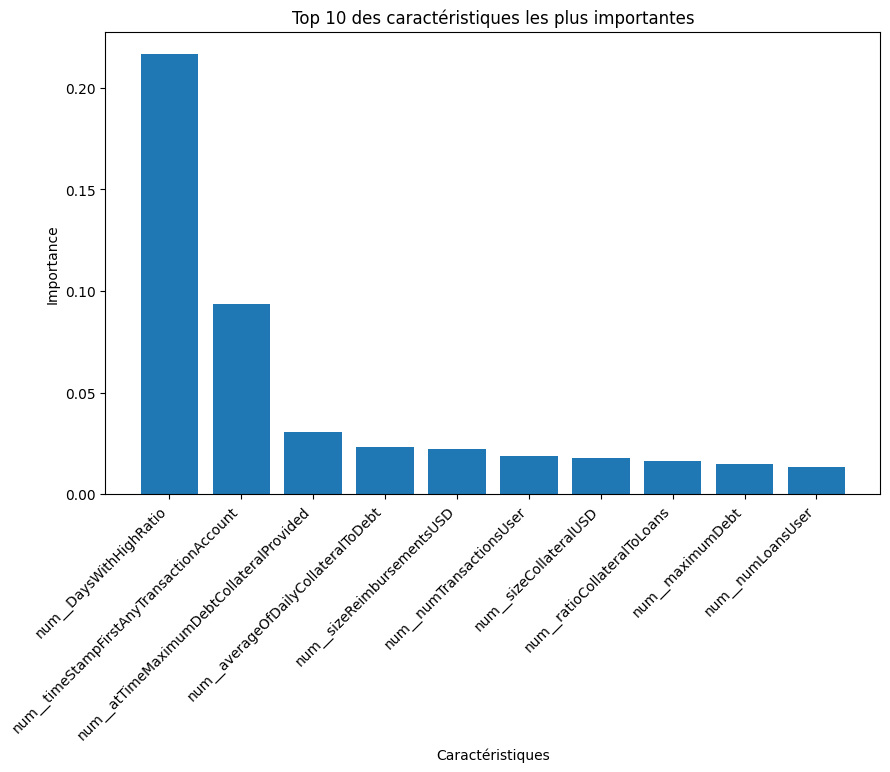

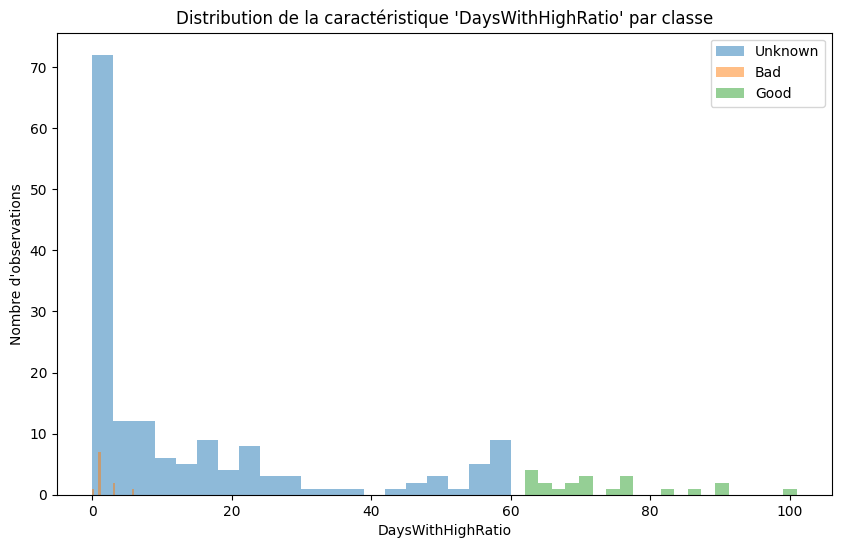

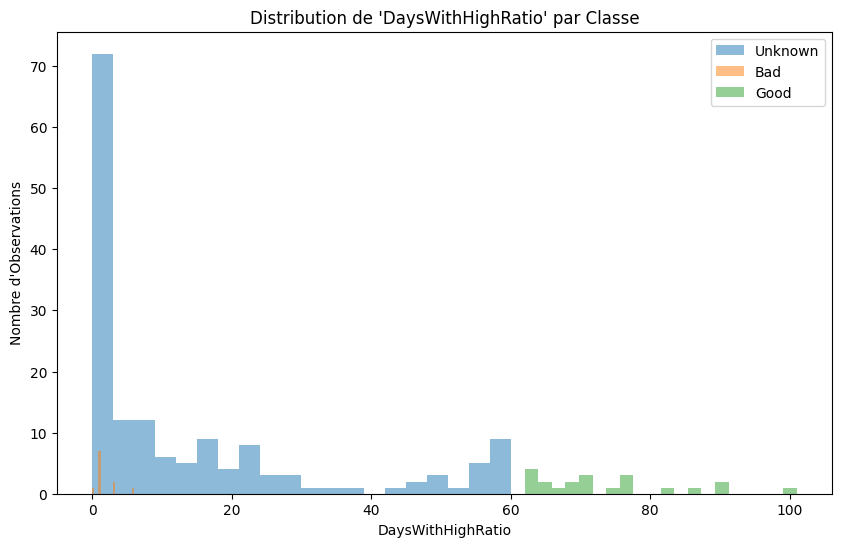

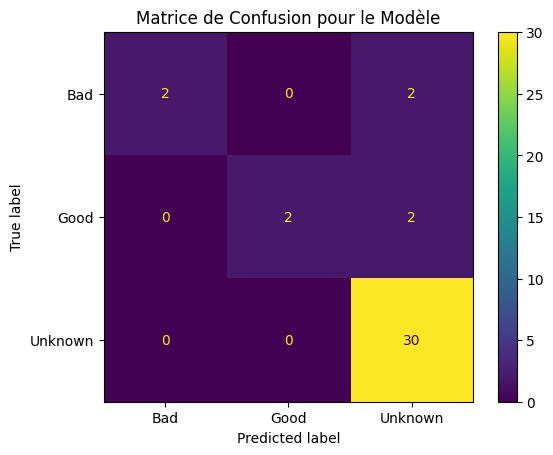

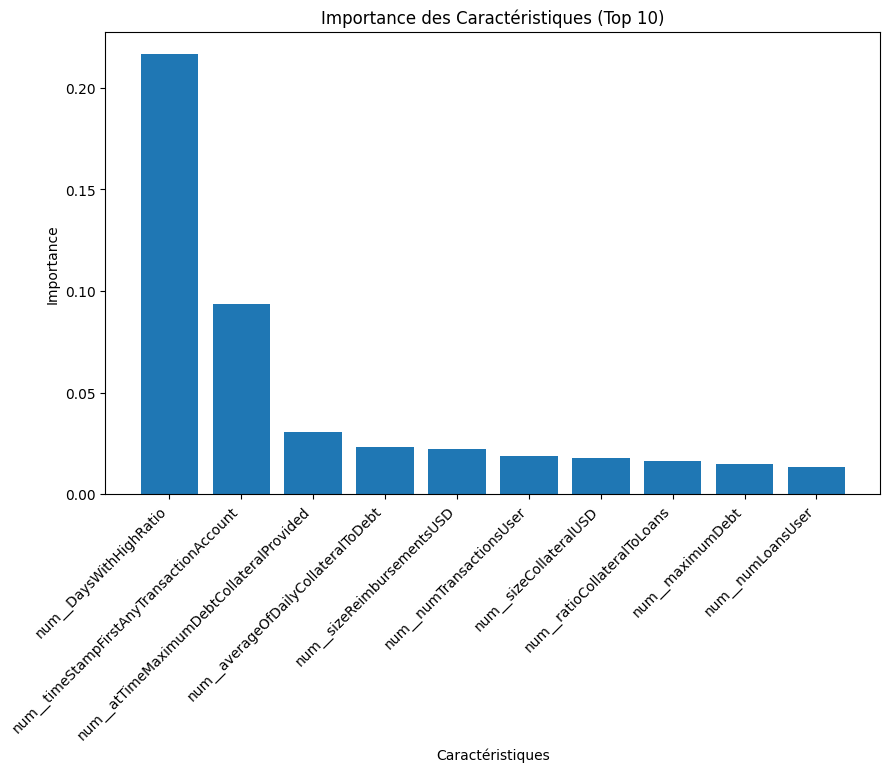

In [26]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('updated_data.csv')
# Création d'une nouvelle colonne binaire pour indiquer si le collatéral a été retiré ou non
data['collateralWithdrawn'] = data['timeStampsWithdrawCollateral'].notnull().astype(int)

# Supprimer la colonne originale 'timeStampsWithdrawCollateral' car nous avons maintenant une représentation binaire
data = data.drop(columns=['timeStampsWithdrawCollateral'])

# Vérifier les modifications
data[['collateralWithdrawn']].head()
# Supprimer l'enregistrement avec des valeurs manquantes
data_cleaned = data.dropna()

# Vérifier si les valeurs manquantes ont été supprimées
remaining_missing_values = data_cleaned.isnull().sum().sum()
remaining_missing_values, data_cleaned.shape
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identification des colonnes catégorielles et numériques
categorical_cols = data_cleaned.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = data_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Supprimer la colonne 'Unnamed: 0' qui semble être un identifiant et la variable cible 'user_class'
categorical_cols.remove('Unnamed: 0')
categorical_cols.remove('user_class')

# Préparation des transformateurs pour les colonnes numériques et catégorielles
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Préparation du préprocesseur pour appliquer ces transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Séparation des données en features et target
X = data_cleaned.drop(columns=['Unnamed: 0', 'user_class'])
y = data_cleaned['user_class']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Application du préprocesseur
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

X_train_transformed.shape, X_test_transformed.shape
# Supprimer uniquement la colonne 'LoanRepaidxPercentInLastyMonths', ainsi que 'Unnamed: 0' (username) et 'user_class'
X_reduced_final = data_cleaned.drop(columns=['Unnamed: 0', 'user_class', 'LoanRepaidxPercentInLastyMonths'])

# Mise à jour des listes des colonnes numériques et catégorielles
numerical_cols_reduced_final = X_reduced_final.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols_reduced_final = X_reduced_final.select_dtypes(include=['object', 'bool']).columns.tolist()

# Mise à jour du préprocesseur pour appliquer ces transformations
preprocessor_reduced_final = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_reduced_final),
        ('cat', categorical_transformer, categorical_cols_reduced_final)
    ])

# Application du préprocesseur
X_train_reduced_final, X_test_reduced_final, y_train_reduced_final, y_test_reduced_final = train_test_split(X_reduced_final, y, test_size=0.2, random_state=42)
X_train_transformed_reduced_final = preprocessor_reduced_final.fit_transform(X_train_reduced_final)
X_test_transformed_reduced_final = preprocessor_reduced_final.transform(X_test_reduced_final)

# Réentraînement du modèle de Forêt Aléatoire
random_forest_model_reduced_final = RandomForestClassifier(random_state=42)
random_forest_model_reduced_final.fit(X_train_transformed_reduced_final, y_train_reduced_final)

# Prédiction sur l'ensemble de test réduit
y_pred_reduced_final = random_forest_model_reduced_final.predict(X_test_transformed_reduced_final)

# Évaluation du modèle réduit
classification_report_result_reduced_final = classification_report(y_test_reduced_final, y_pred_reduced_final)
confusion_matrix_result_reduced_final = confusion_matrix(y_test_reduced_final, y_pred_reduced_final)


import matplotlib.pyplot as plt
import numpy as np

# Obtenir l'importance des caractéristiques du modèle de forêt aléatoire
feature_importances = random_forest_model_reduced_final.feature_importances_

# Récupérer les noms des caractéristiques après la transformation
feature_names_transformed = preprocessor_reduced_final.get_feature_names_out()

# Trier les caractéristiques par importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names_transformed[sorted_indices]

# Afficher les 10 caractéristiques les plus importantes
plt.figure(figsize=(10, 6))
plt.title("Top 10 des caractéristiques les plus importantes")
plt.bar(range(10), sorted_feature_importances[:10], align='center')
plt.xticks(range(10), sorted_feature_names[:10], rotation=45, ha='right')
plt.xlabel('Caractéristiques')
plt.ylabel('Importance')
plt.show()

# Sélectionner la caractéristique la plus importante
top_feature = sorted_feature_names[0]

# Décoder le nom de la caractéristique pour obtenir le nom original dans le jeu de données
original_feature_name = top_feature.split("__")[1] if "__" in top_feature else top_feature

# Afficher la distribution de cette caractéristique pour chaque classe
plt.figure(figsize=(10, 6))
for class_name in data_cleaned['user_class'].unique():
    subset = data_cleaned[data_cleaned['user_class'] == class_name]
    plt.hist(subset[original_feature_name], bins=20, alpha=0.5, label=class_name)

plt.title(f"Distribution de la caractéristique '{original_feature_name}' par classe")
plt.xlabel(original_feature_name)
plt.ylabel('Nombre d\'observations')
plt.legend()
plt.show()

# Création d'un DataFrame pour comparer les prédictions avec les valeurs réelles
comparison_df = pd.DataFrame({'Actual': y_test_reduced_final, 'Predicted': y_pred_reduced_final})

# Trouver un exemple d'une bonne classification
correct_classification = comparison_df[comparison_df['Actual'] == comparison_df['Predicted']].sample(1)
correct_index = correct_classification.index[0]

# Trouver un exemple d'une mauvaise classification
incorrect_classification = comparison_df[comparison_df['Actual'] != comparison_df['Predicted']].sample(1)
incorrect_index = incorrect_classification.index[0]

# Extraire les détails de ces deux exemples du jeu de données original
correct_example = data_cleaned.loc[correct_index]
incorrect_example = data_cleaned.loc[incorrect_index]

correct_example, incorrect_example

# Histogramme de la distribution des scores pour chaque classe
plt.figure(figsize=(10, 6))
for class_name in data_cleaned['user_class'].unique():
    subset = data_cleaned[data_cleaned['user_class'] == class_name]
    plt.hist(subset['DaysWithHighRatio'], bins=20, alpha=0.5, label=class_name)

plt.title("Distribution de 'DaysWithHighRatio' par Classe")
plt.xlabel('DaysWithHighRatio')
plt.ylabel('Nombre d\'Observations')
plt.legend()
plt.show()

# Matrice de confusion pour le modèle
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test_reduced_final, y_pred_reduced_final)
plt.title('Matrice de Confusion pour le Modèle')
plt.show()

# Graphique de l'importance des caractéristiques
plt.figure(figsize=(10, 6))
plt.title("Importance des Caractéristiques (Top 10)")
plt.bar(range(10), sorted_feature_importances[:10], align='center')
plt.xticks(range(10), sorted_feature_names[:10], rotation=45, ha='right')
plt.xlabel('Caractéristiques')
plt.ylabel('Importance')
plt.show()
# #print(df.describe())
# df = df.drop(columns=['Unnamed: 0'])
# #df = df.drop(columns=['Calendar'])
# for col in ['timeStampsSupplyCollateral', 'timeStampsLoans', 'timeStampsReimbursement', 'timeStampsWithdrawCollateral','maximumDebt', 'atTimeMaximumDebtCollateralProvided']:
#     df= df.drop(columns=col)

# rows_with_nan = df[df.isna().any(axis=1)]

# df.dropna()
# df['LoanRepaidxPercentInLastyMonths'] = df['LoanRepaidxPercentInLastyMonths'].astype(int)
# le = preprocessing.LabelEncoder()
# df['MostFrequentTransactionTimeOfDay'] = le.fit_transform(df['MostFrequentTransactionTimeOfDay'])
# df['user_class'] = le.fit_transform(df['user_class'])
# #print(df.describe())
# scaler = StandardScaler()
# num_cols = ['sizeLoansUSD', 'sizeCollateralUSD', 'sizeReimbursementsUSD', 'numLoansUser', 'ratioCollateralToLoans', 'averageOfDailyCollateralToDebt', 'numTransactionsUser', 'DaysWithHighRatio']
# df[num_cols] = scaler.fit_transform(df[num_cols])
# for cols in ['DaysWithHighRatio','timeStampFirstAnyTransactionAccount','LoanRepaidxPercentInLastyMonths']:
#   df = df.drop(columns=cols)
# X = df.drop('user_class', axis=1)
# y = df['user_class']

# #print(X.head())
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# X_train = X_train.dropna()
# y_train = y_train[X_train.index]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


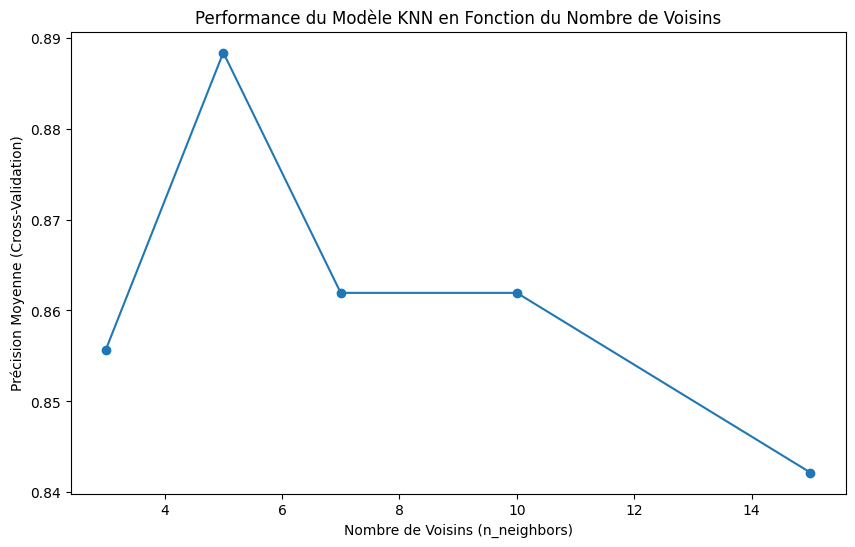

In [27]:

from sklearn.neighbors import KNeighborsClassifier

# Entraînement du modèle KNN
knn_model = KNeighborsClassifier(n_neighbors=5)  # Utilisation de 5 voisins pour commencer
knn_model.fit(X_train_transformed_reduced_final, y_train_reduced_final)

# Prédiction sur l'ensemble de test
y_pred_knn = knn_model.predict(X_test_transformed_reduced_final)

# Évaluation du modèle KNN
classification_report_knn = classification_report(y_test_reduced_final, y_pred_knn)
confusion_matrix_knn = confusion_matrix(y_test_reduced_final, y_pred_knn)

classification_report_knn, confusion_matrix_knn

from sklearn.model_selection import cross_val_score

# Tester différentes valeurs pour 'n_neighbors'
neighbor_values = [3, 5, 7, 10, 15]
cross_val_scores = []

for k in neighbor_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model, X_train_transformed_reduced_final, y_train_reduced_final, cv=5)
    cross_val_scores.append(scores.mean())

# Afficher les résultats
plt.figure(figsize=(10, 6))
plt.plot(neighbor_values, cross_val_scores, marker='o')
plt.title('Performance du Modèle KNN en Fonction du Nombre de Voisins')
plt.xlabel('Nombre de Voisins (n_neighbors)')
plt.ylabel('Précision Moyenne (Cross-Validation)')
plt.show()
# knn = KNeighborsClassifier(n_neighbors=3)

# knn.fit(X_train, y_train)

# y_pred = knn.predict(X_test)
# print('Printing informations')
# print( 'ypred:', (y_pred))
# #print( 'y_train:', y_train)
# #print( 'X_test:', X_test)
# # Convertir les prédictions en DataFrame pandas
# predictions_df = pd.DataFrame(y_pred, columns=['Prediction'])
# information_df = pd.DataFrame(X_test,columns=['X_test'])
# combined_df = pd.concat([information_df, predictions_df], axis=1)
# # Exporter le DataFrame en fichier CSV
# combined_df.to_csv('mes_predictions.csv', index=False)
# accuracy = accuracy_score(y_test, y_pred)
# print('Accuracy:', accuracy)
# df__ = pd.DataFrame(X_test)
# df__.to_csv('mon_fichier.csv', index=False)

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'n_neighbors': [3],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2],
}
knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Meilleurs paramètres : {best_params}")
print(f'Accuracy avec meilleurs paramètres: {accuracy}')
print('Classification Report avec meilleurs paramètres:\n', report)


Meilleurs paramètres : {'algorithm': 'auto', 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Accuracy avec meilleurs paramètres: 0.8125
Classification Report avec meilleurs paramètres:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.89      0.91      0.90        43

    accuracy                           0.81        48
   macro avg       0.30      0.30      0.30        48
weighted avg       0.79      0.81      0.80        48



In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import numpy as np

rfc = RandomForestClassifier( n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         3
           2       0.91      0.95      0.93        43

    accuracy                           0.88        48
   macro avg       0.47      0.48      0.48        48
weighted avg       0.84      0.88      0.86        48



Analyze performance: Finally, we will analyze the performance of our machine learning model and evaluate its effectiveness in predicting user behavior accurately.

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

best_model = grid_search.best_estimator_

predictions = best_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Meilleurs paramètres : {best_params}")
print(f'Accuracy avec meilleurs paramètres: {accuracy}')
print('Classification Report avec meilleurs paramètres:\n', report)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

KeyboardInterrupt: ignored

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

In [ ]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

logistic_regression = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_


best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Meilleurs paramètres : {best_params}")
print(f'Accuracy avec meilleurs paramètres: {accuracy}')
print('Classification Report avec meilleurs paramètres:\n', report)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

model = SVC(kernel='linear', C=1.0, decision_function_shape='ovr')

model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
}

svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Meilleurs paramètres : {best_params}")
print(f'Accuracy avec meilleurs paramètres: {accuracy}')
print('Classification Report avec meilleurs paramètres:\n', report)

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
model = XGBClassifier(objective='multi:softmax', num_class=3, seed=42)

model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

xgb = XGBClassifier(objective='multi:softmax', num_class=3, seed=42)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

best_model = grid_search.best_estimator_

predictions = best_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Meilleurs paramètres : {best_params}")
print(f'Accuracy avec meilleurs paramètres: {accuracy}')
print('Classification Report avec meilleurs paramètres:\n', report)

In [ ]:

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

knn_model = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', p=2)
rf_model = RandomForestClassifier(max_depth=None, max_features='auto', min_samples_leaf=2, min_samples_split=5, n_estimators=100)
logistic_model = LogisticRegression(C=0.001, penalty='l2')
svm_model = SVC(C=0.1, degree=2, kernel='linear')
xgb_model = XGBClassifier(colsample_bytree=1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1)

models = [('knn', knn_model), ('random_forest', rf_model), ('logistic_regression', logistic_model),
          ('svm', svm_model), ('xgboost', xgb_model)]
accuracy_scores = []
classification_reports = []
confusion_matrices = []
for model_name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append((model_name, accuracy))
    report = classification_report(y_test, predictions, output_dict=True)
    classification_reports.append((model_name, report))
    conf_matrix = confusion_matrix(y_test, predictions)
    confusion_matrices.append((model_name, conf_matrix))
for model_name, accuracy in accuracy_scores:
    print(f'{model_name} Accuracy: {accuracy}')
plt.figure(figsize=(10, 6))
classes = [
    "sizeLoansUSD",
    "sizeCollateralUSD",
    "sizeReimbursementsUSD",
    "numLoansUser",
    "numReimbursementsUser",
    "ratioCollateralToLoans",
    "averageOfDailyCollateralToDebt",
    "numTransactionsUser",
    "timeStampFirstAnyTransactionAccount",
    "numLiquidations",
    "timeStampsLiquidations",
    "datesLiquidation",
    "hashLiquidations",
    "liquidators",
    "amountLiquidated",
    "NumLiqudiations",
    "MostFrequentTransactionTimeOfDay",
    "DaysWithHighRatio",
    "LoanRepaidxPercentInLastyMonths",
    "user_class"
]
for model_name, conf_matrix in confusion_matrices:
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, label=model_name)
plt.title('Matrices de Confusion Comparatives')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.legend()
plt.show()

for model_name, report in classification_reports:
    print(f'\n{model_name} Classification Report:\n', report)